# Reconaissance des régions actives et structures



In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
import sunpy.sun

from sunpy.coordinates import frames

import sys
sys.path.insert(0, '..')
from module import readFitsBz2, centerDisk


In [17]:
# 'data/L2/imoa_03933_l2_20220326_13422771_emi1.fts.bz2'

# 'data/L2/imoa_03933_l2_20240228_14452489_emi1.fts.bz2'
# 'data/L2/imoa_03933_l2_20230323_09150652_emi1.fts.bz2'
# 'data/L2/imoa_03933_l2_20200228_08560700_emi1.fts.bz2'

# 'data/L2/imoa_03933_l2_20240228_12402419_emi1.fts.bz2'
# 'data/L2/imoa_03933_l2_20240229_08582618_emi1.fts.bz2'

# 'data/L2/imoa_03933_l2_20240323_13052647_emi1.fts.bz2'

hdu = readFitsBz2('../'+'data/L2/imoa_03933_l2_20240319_15102678_emi1.fts.bz2')

hdu.data = np.flip(centerDisk(hdu.data), axis=0)


coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime=hdu.header['DATE_OBS'],
                observer='earth', frame=frames.Helioprojective, )
    
scale = [0.5*(hdu.header['NAXIS1']-100)/hdu.header['RSUN_OBS'], 0.5*(hdu.header['NAXIS2']-100)/hdu.header['RSUN_OBS']]
header = sunpy.map.make_fitswcs_header(hdu.data, coord,
                                    reference_pixel=[hdu.header['CRPIX1'], hdu.header['CRPIX2']]*u.pixel,
                                    scale=scale*u.arcsec/u.pixel,
                                    )

header['rsun_obs'] = hdu.header['rsun_obs']

map = sunpy.map.Map(hdu.data, header)

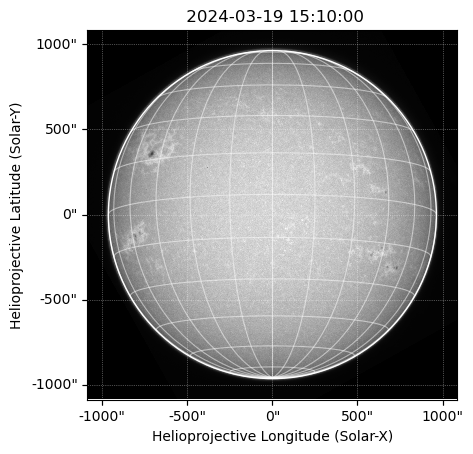

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection=map)
map.plot(axes=ax)
map.draw_limb(axes=ax)
map.draw_grid(axes=ax)
plt.show()

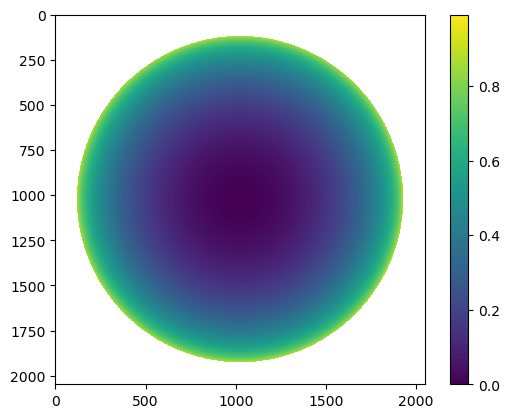

In [19]:
coordinates = sunpy.map.all_coordinates_from_map(map)
weights = coordinates.transform_to("heliocentric").z.value

mu = (weights / np.nanmax(weights))

weights = np.ones(mu.shape) - mu

#weights[np.isnan(weights)] = 0

fig, ax = plt.subplots()
im = ax.imshow(weights)
fig.colorbar(im)

plt.show()

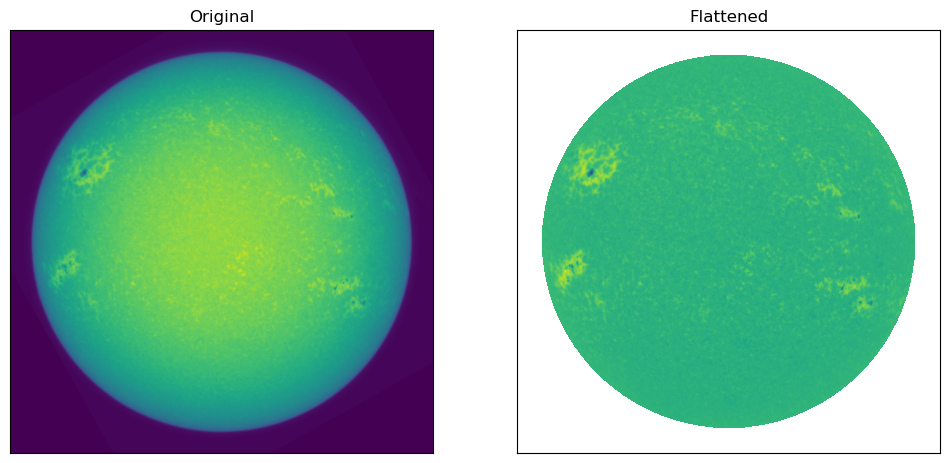

In [21]:
flattened = map.data + 1.3*np.mean(map.data)*weights

plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(map.data, origin='lower')
plt.title('Original'), plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(flattened, origin='lower')
plt.title('Flattened'), plt.xticks([]), plt.yticks([]);

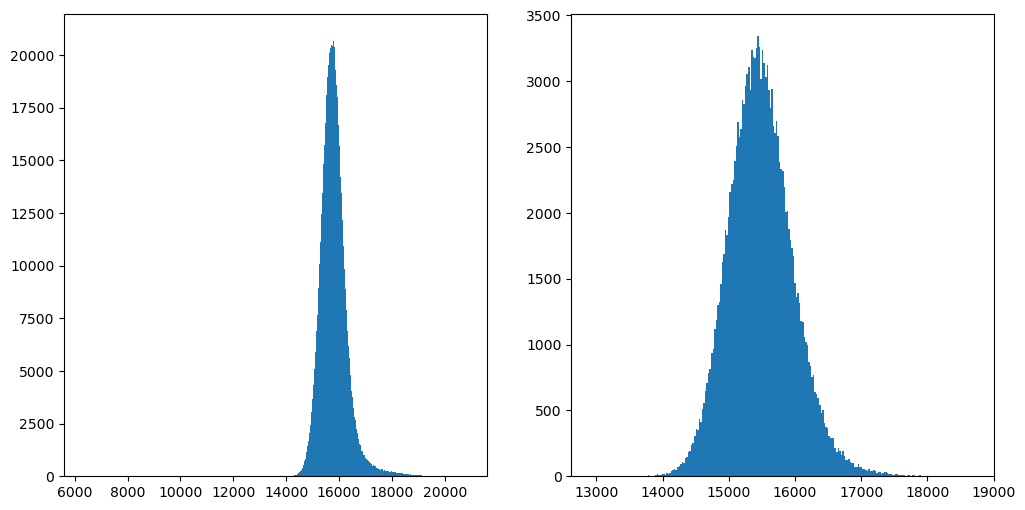

In [22]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.hist(flattened.flatten(), bins='auto');

plt.subplot(122)
plt.hist(map.data[800:1200,800:1200].flatten(), bins='auto');

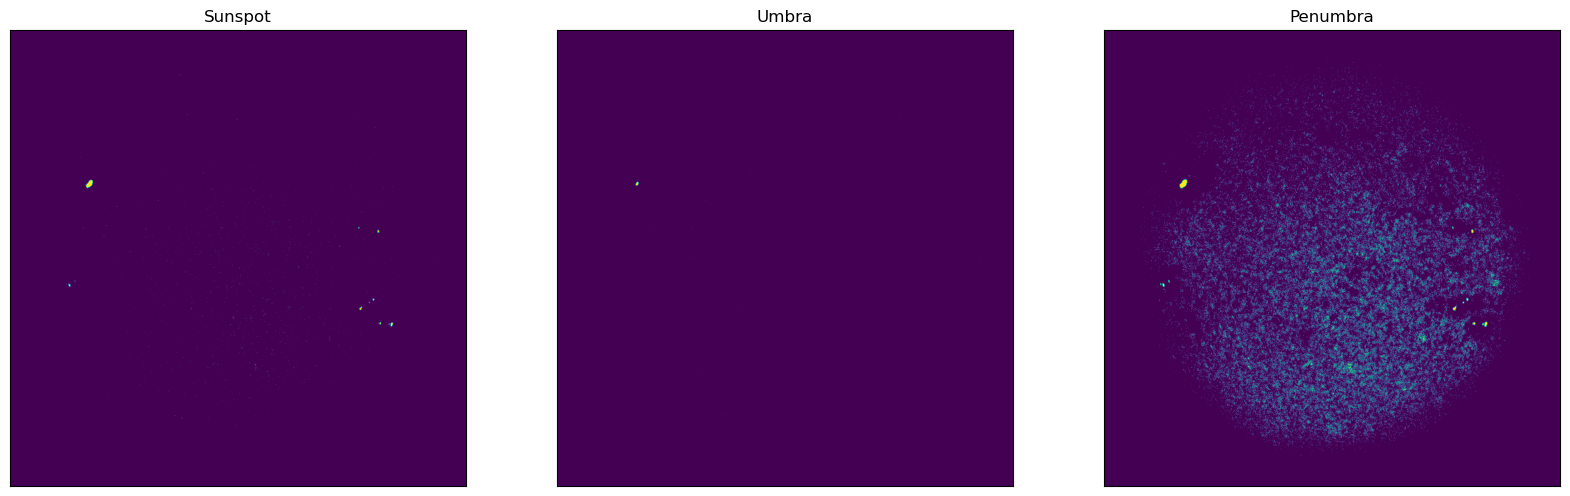

In [23]:
ret, umbra = cv.threshold(flattened,0.7*np.nanmedian(flattened),255,cv.THRESH_BINARY_INV)
ret, sunspot = cv.threshold(flattened,0.91*np.nanmedian(flattened),255,cv.THRESH_BINARY_INV)
ret, penumbra = cv.threshold(flattened,0.96*np.nanmedian(flattened),255,cv.THRESH_BINARY_INV)

plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(sunspot, origin='lower')
plt.title('Sunspot'), plt.xticks([]), plt.yticks([]);
plt.subplot(132),plt.imshow(umbra, origin='lower')
plt.title('Umbra'), plt.xticks([]), plt.yticks([]);
plt.subplot(133),plt.imshow(penumbra, origin='lower')
plt.title('Penumbra'), plt.xticks([]), plt.yticks([]);


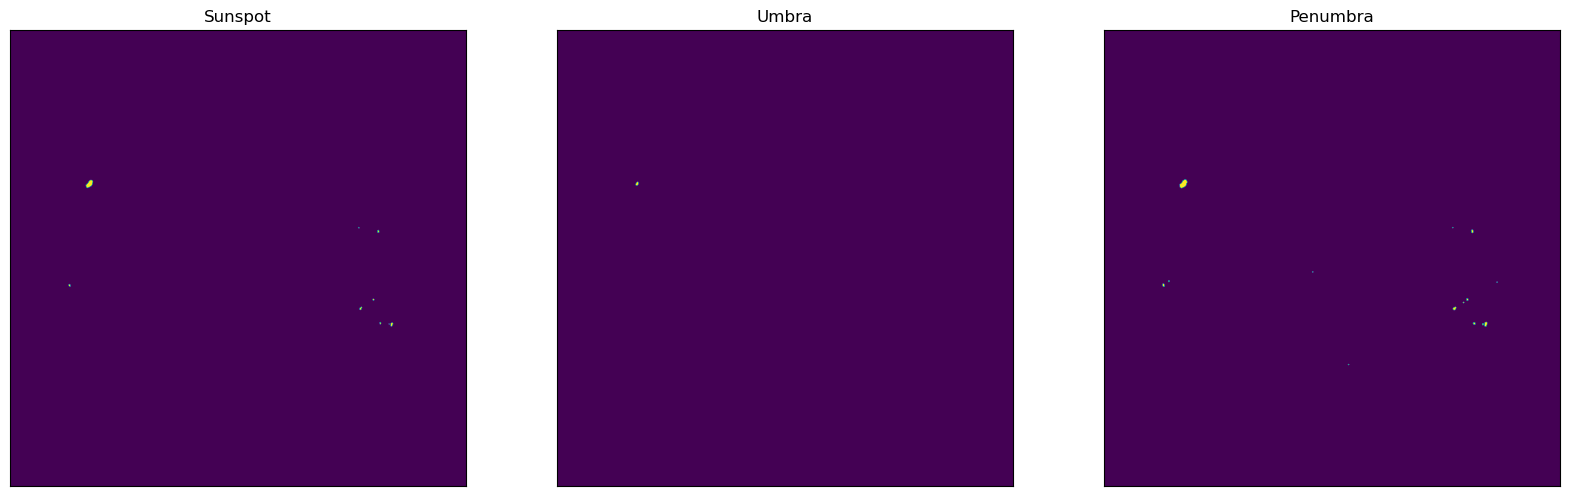

In [24]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
umbra = cv.morphologyEx(umbra.astype(np.uint8), cv.MORPH_OPEN, kernel)
cv.circle(umbra, (1024,1024), int(map.meta['rsun_obs']-15),color=(0,0,0), thickness = 30);

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
sunspot = cv.morphologyEx(sunspot.astype(np.uint8), cv.MORPH_OPEN, kernel)
cv.circle(sunspot, (1024,1024), int(map.meta['rsun_obs']-15),color=(0,0,0), thickness = 30);

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
penumbra = cv.morphologyEx(penumbra.astype(np.uint8), cv.MORPH_OPEN, kernel)
cv.circle(penumbra, (1024,1024), int(map.meta['rsun_obs']-15),color=(0,0,0), thickness = 30);

plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(sunspot, origin='lower')
plt.title('Sunspot'), plt.xticks([]), plt.yticks([]);
plt.subplot(132),plt.imshow(umbra, origin='lower')
plt.title('Umbra'), plt.xticks([]), plt.yticks([]);
plt.subplot(133),plt.imshow(penumbra, origin='lower')
plt.title('Penumbra'), plt.xticks([]), plt.yticks([]);

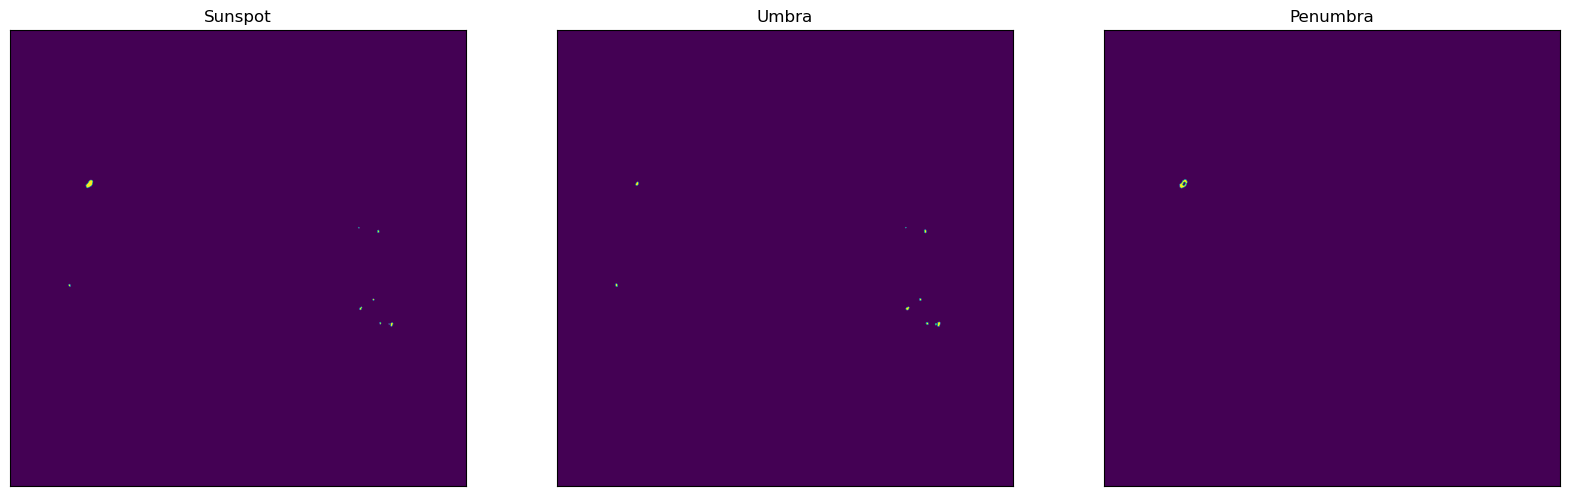

In [25]:
# Removes bad penumbra using sunspot
n_labels, labels = cv.connectedComponents(penumbra, connectivity=8)

keep_label_list = np.unique(cv.bitwise_and(labels,sunspot.astype(np.int32)))
mask = np.isin(labels, keep_label_list)

penumbra[~mask] = 0
labels[~mask] = 0

# turns penumbra with no umbra into umbra
remove_label_list = np.unique(cv.bitwise_and(labels,umbra.astype(np.int32)))
mask = np.isin(labels, remove_label_list)

umbra[~mask]=255

penumbra = penumbra - umbra


plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(sunspot, origin='lower')
plt.title('Sunspot'), plt.xticks([]), plt.yticks([]);
plt.subplot(132),plt.imshow(umbra, origin='lower')
plt.title('Umbra'), plt.xticks([]), plt.yticks([]);
plt.subplot(133),plt.imshow(penumbra, origin='lower')
plt.title('Penumbra'), plt.xticks([]), plt.yticks([]);

## Label

In [26]:
img = cv.convertScaleAbs(map.data, alpha=(255.0/65535.0)).astype(np.uint8)

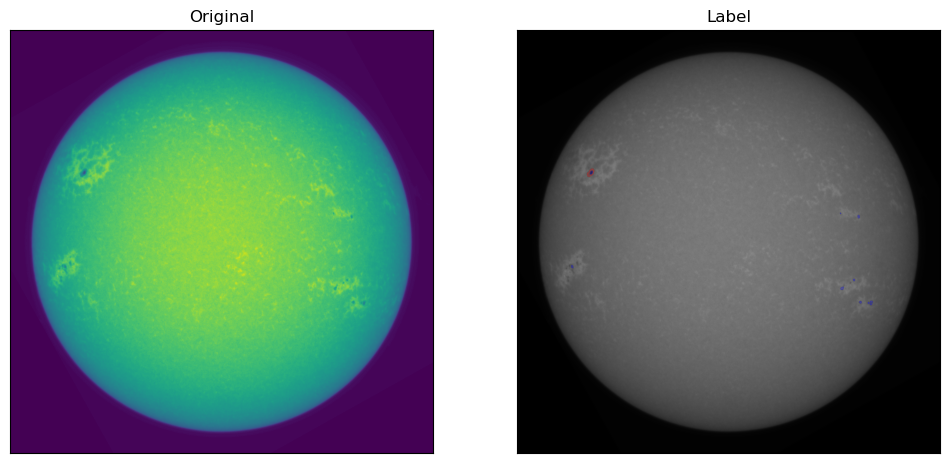

In [27]:
color_image = np.zeros((umbra.shape[0], umbra.shape[1], 3), dtype=np.uint8)
color_image[umbra == 255] = [0, 0, 255] 
color_image[penumbra == 255] = [255, 0, 0] 

img_label = cv.addWeighted(cv.cvtColor(img, cv.COLOR_GRAY2RGB),2,color_image,0.2,0)

contours, hierarchy = cv.findContours(umbra, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_label, contours, -1, (0,0,255), 1)

contours, hierarchy = cv.findContours(penumbra, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_label, contours, -1, (255,0,0), 1)

plt.figure(figsize=(12,12))
plt.subplot(121), plt.imshow(img, origin='lower');
plt.title('Original'), plt.xticks([]), plt.yticks([]);
plt.subplot(122), plt.imshow(img_label, origin='lower');
plt.title('Label'), plt.xticks([]), plt.yticks([]);

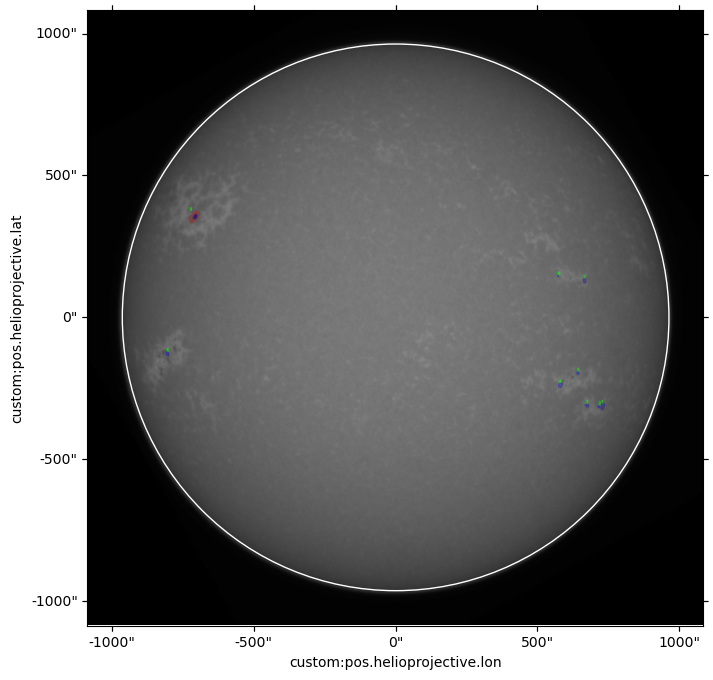

In [28]:
n_labels, labels, stats, centroids = cv.connectedComponentsWithStats(umbra|penumbra, connectivity=8)

img_label_id = img_label.copy()

font = cv.FONT_HERSHEY_DUPLEX

fontScale = 0.5

color = (0, 255, 0) 

thickness = 1

for idx in range(1,n_labels):
    x,y,w,h = cv.boundingRect((labels==idx).astype(np.uint8))
    img_label_id = cv.putText(img_label_id, f'{idx}', (x, y+h), font,  
                fontScale, color, thickness, cv.LINE_AA, True)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=map)
plt.imshow(img_label_id, origin='lower');
map.draw_limb(axes=ax)

plt.show()

## Area

"A simple ratio of pixels contained in each sunspot to the total number of pixels on the disk of the sun gives the relative size of the sunspot to the solar disk. This value is then multiplied by $1 × 10^6$ to put the value in millionths of a solar hemisphere and finally divided by the cosine of the angle of the sunspot off the center of the solar disk, which is the same 𝜇 from equation 4 from Section 3.2. , since objects near the limb of the Sun appear smaller than objects toward the center of the solar disk. The combined equation for the area calculation is given as :

$$Area = \frac{A}{2\pi r^2} \frac{1 \times 10^6}{\mu}$$

Where 𝐴 is the number of pixels contained by the analyzed sunspot and 𝑟 is the radius of
the sun in pixels from the edge detection algorithm." [1]

µSH : Millionths of Solar Hemisphere


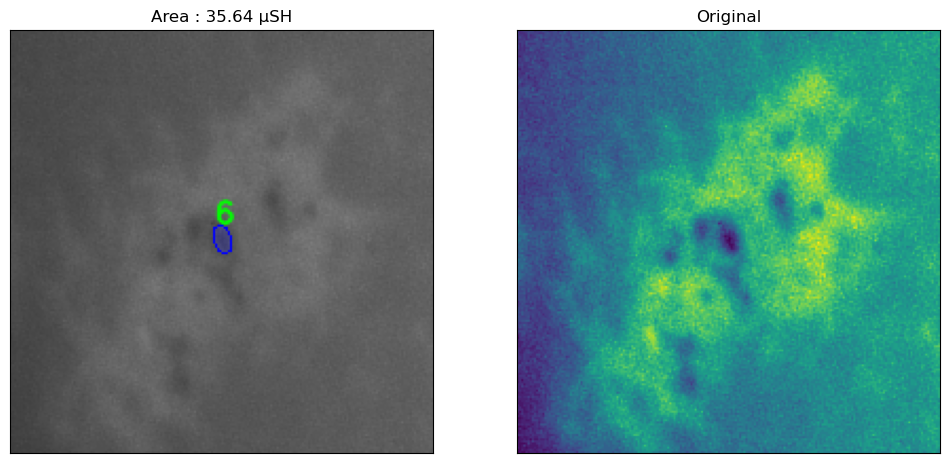

In [49]:
r = map.meta['RSUN_OBS']

label = 6
centroid = centroids[label].astype(np.uint16)
area = (np.sum(labels==label) / (2*np.pi*r**2)) * (10**6 / mu[centroid[1],centroid[0]])

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(img_label_id[centroid[1]-100:centroid[1]+100, centroid[0]-100:centroid[0]+100], origin='lower');
plt.title(f'Area : {area:.2f} µSH'), plt.xticks([]), plt.yticks([]);
plt.subplot(122)
plt.imshow(img[centroid[1]-100:centroid[1]+100, centroid[0]-100:centroid[0]+100], origin='lower');
plt.title('Original'), plt.xticks([]), plt.yticks([]);

## Tracking

Rotation model : Howard

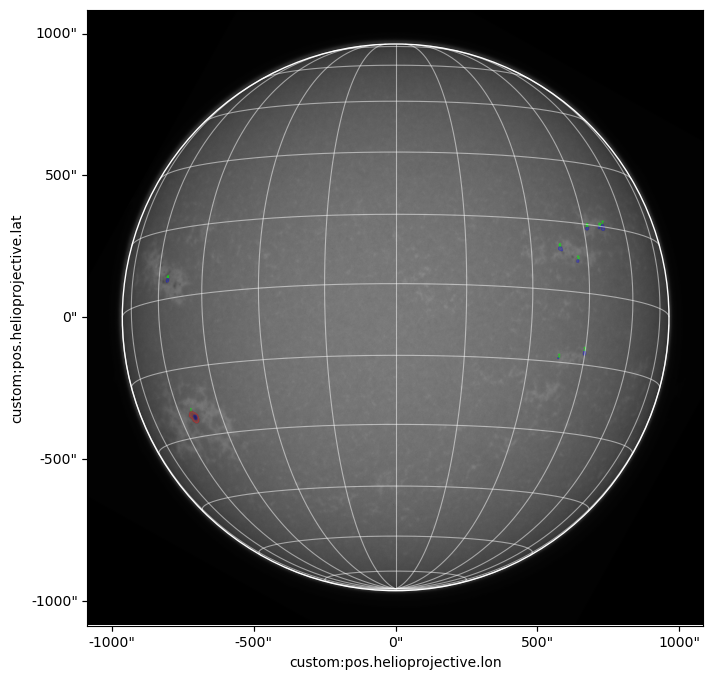

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=map)
plt.imshow(img_label_id, origin='lower');
map.draw_limb(axes=ax)
map.draw_grid(axes=ax)

plt.show();

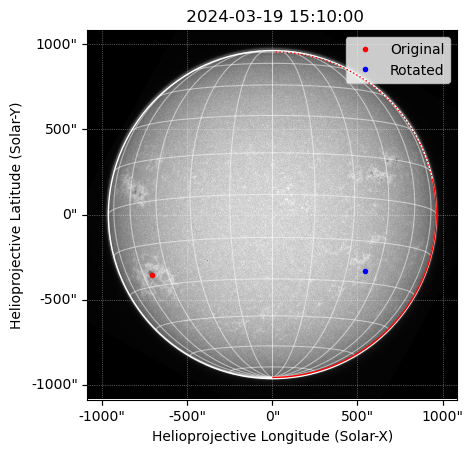

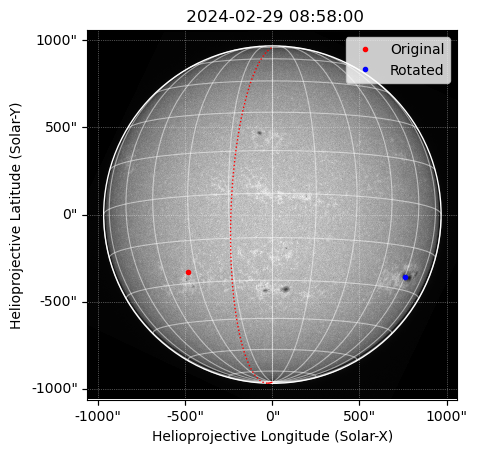

In [15]:
from sunpy.coordinates import RotatedSunFrame
from sunpy.visualization import drawing
from module import getHeader, readFitsBz2, centerDisk

hdu = readFitsBz2('data/L2/imoa_03933_l2_20240229_08582618_emi1.fts.bz2')
hdu.data = centerDisk(hdu.data)
header = getHeader(hdu)

map2 = sunpy.map.Map(hdu.data, header)

label = 1

point = map.pixel_to_world(centroids[label][0]*u.pixel, (centroids[label][1])*u.pixel)

diffrot_point = SkyCoord(RotatedSunFrame(base=point, rotated_time=map2.date))

transformed_diffrot_point = diffrot_point.transform_to(map.coordinate_frame)

fig = plt.figure()
ax = fig.add_subplot(projection=map)
map.plot(axes=ax)
map.draw_limb(axes=ax)
map.draw_grid(axes=ax)
drawing.prime_meridian(ax, color='red')
ax.plot_coord(point, 'r.', fillstyle='full', label='Original')
ax.plot_coord(transformed_diffrot_point, 'b.', fillstyle='full', label='Rotated')
ax.legend(loc='upper right')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection=map2)
map2.plot(axes=ax)
map2.draw_limb(axes=ax)
map2.draw_grid(axes=ax)
drawing.prime_meridian(ax, color='red')
ax.plot_coord(point, 'r.', fillstyle='full', label='Original')
ax.plot_coord(transformed_diffrot_point, 'b.', fillstyle='full', label='Rotated')
ax.legend(loc='upper right')

plt.show()

**Tracking :**

- Mean shift ?
- Template matching

**Ressources :** 

[1] Townsend, MacLane A., "Automated Sunspot Classification and Tracking Using SDO/HMI Imagery" (2016). Theses and Dissertations.
349.
https://scholar.afit.edu/etd/349